# Imports

In [1]:
import scanpy as sc
import matplotlib.pyplot as pl
import pandas as pd
import numpy as np
import os
import sys
import scvelo as scv  # has better plotting capabilities than scanpy
scv.settings.verbosity=1
from tqdm.notebook import tqdm

# Jupyter stuff
from IPython.display import clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:99% !important; }</style>"))
%matplotlib inline

# Load and prime data

In [5]:
DIR = '/fast/work/projects/bluethgen_landthaler/Cov19_Hamster/data/Impf/'
adata = sc.read(DIR+'/exp2_lung_tcells.h5')

In [6]:
# For convenience
adata.obs['celltype_treatment'] = [f'{c}_{t}' for c,t in zip(adata.obs.celltype, adata.obs.treatment)]
adata.obs['cluster_treatment'] = [f'{c}_{t}' for c,t in zip(adata.obs.seurat_clusters, adata.obs.treatment)]
adata.obs['vac'] = ['unvaccinated' if 'aaUntr'==x else 'vaccinated' for x in adata.obs.treatment]
adata.obs['cluster_vac'] = [f'{c}_{t}' for c,t in zip(adata.obs.seurat_clusters, adata.obs.vac)]

In [8]:
def rsum(X, axis):
    # handles sparse sum, returns array instead of matrix object
    return np.ravel(np.sum(X, axis=axis))

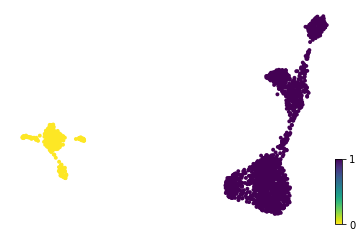

(1639, 7108)

In [9]:
# filter genes to be expressed in at least a few cells and have at least a few counts in total
limit_cells = (rsum(adata.layers['counts']>0, axis=0) > 100)
limit_counts = rsum(adata.layers['counts'], axis=0) > 200

# this gets rid of NK cells (the clusters on the left)
# Alternatively you could throw out NK clusters by cluster, 
# but there are 2 or 3 misclusters cells which will mess up the umap then.
mask = adata.obsm['X_umap_seurat'][:,0]>-5
scv.pl.scatter(adata, basis='umap_seurat', color=mask, legend_loc='on data')
adata = adata[mask, limit_cells & limit_counts].copy()
sc.tl.umap(adata)
adata.shape

# UMAP with TRM cell signature from Kumar et al. (Fig4I)

In [19]:
def specify_genes(genes, source_species='mouse', target_species='human'):
    genes = genes if isinstance(genes, list) else list(genes) if (isinstance(genes, np.ndarray) or isinstance(genes, pd.Index)) else [genes]
    # load human-mouse orthology
    tab = pd.read_csv('../metadata/human_mouse_orthology_HMD_HumanPhenotype.rpt', sep='\t',
                  names=['human', 'human_gene_number (HGNC)', 'mouse', 'mouse_gene_number (MGI)', 'mouse protein'], usecols=[0,1,2,3,4])
    human_mouse_orthology_dict = dict(zip(tab.human, tab.mouse))
    mouse_human_orthology_dict = {key: value for (value, key) in human_mouse_orthology_dict.items()}
    # translate genes
    # TODO the mapping could lead to duplicate genes, is that a problem?
    if source_species=='mouse' and target_species=='human':
        return [mouse_human_orthology_dict[x] if x in mouse_human_orthology_dict.keys() else x.upper() for x in genes]
    elif source_species=='human' and target_species=='mouse':
        return [human_mouse_orthology_dict[x] if x in human_mouse_orthology_dict.keys() else x.capitalize() for x in genes]
    elif target_species is 'mouse':
        return [x.capitalize() for x in genes]
    elif target_species is 'human':
        return [x.upper() for x in genes]
    else:
        raise ValueError('Species '+target_species+' not known.')

In [20]:
# Read DEG list
tab = pd.read_excel('../metadata/kumar_et_al-supplement-2.xlsx', skiprows=2, usecols=[0,1,2,3,4], index_col=0)
tab = tab[(tab.PValue<0.01) & (np.abs(tab.logFC)>1)]
up = list(np.array(tab[tab.logFC>0].index, dtype=str))
down = list(np.array(tab[tab.logFC<0].index, dtype=str))

# From human to mouse
up = [x for x in specify_genes(up, 'human', 'mouse') if x in adata.var_names]
down = [x for x in specify_genes(down, 'human', 'mouse') if x in adata.var_names]

# Score up and down separately
sc.tl.score_genes(adata, up, score_name='kumar_up')
sc.tl.score_genes(adata, down, score_name='kumar_down')

# Final score and minmax normalization
X = adata.obs['kumar_up'] - adata.obs['kumar_down']
X -= np.min(X)
X /= np.max(X)
adata.obs['kumar_TRM_cell_signature_score'] = X

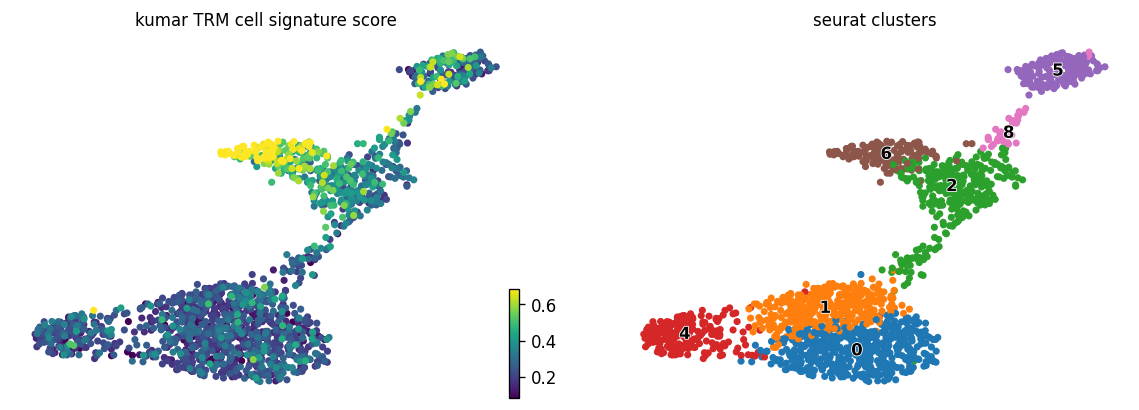

In [21]:
# plot
scv.pl.scatter(adata, basis='umap_seurat', color=['kumar_TRM_cell_signature_score', 'seurat_clusters'], perc=[3,97], legend_loc='on data', dpi=120, show=False, cmap='viridis')
pl.savefig('../figures/Fig4I_umaps.pdf', bbox_inches='tight', dpi=300)

# PAGA (Fig4J)

See Wolf, F.A., Hamey, F.K., Plass, M. et al. PAGA: graph abstraction reconciles clustering with trajectory inference through a topology preserving map of single cells. Genome Biol 20, 59 (2019). https://doi.org/10.1186/s13059-019-1663-x.

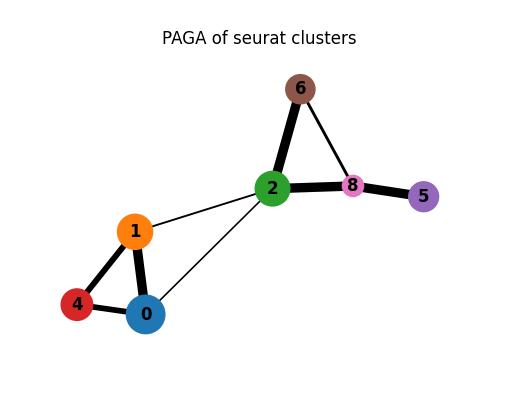

In [22]:
sc.tl.paga(adata, 'seurat_clusters')
cm = 1/2.54  # centimeters in inches
fig, axs = pl.subplots(1, 1, dpi=300, figsize=[5*cm,5*cm*2/3])
ax = axs
sc.pl.paga(adata, ax=ax, frameon=False, node_size_scale=0.3, show=False, threshold=0.1, edge_width_scale=0.3, fontsize=4)
ax.set_xlim(np.array(ax.get_xlim())*1.2)
ax.set_ylim(np.array(ax.get_ylim())*1.2)
ax.set_title('PAGA of seurat clusters', fontsize=4)

pl.savefig('../figures/Fig4J_PAGA.pdf', bbox_inches='tight')
pl.show()

# Diffusion Analysis (Fig4K and FigS15)

In [14]:
# run diffmap. DC1 is equivalent to diffusion pseudotime.
sc.tl.diffmap(adata)

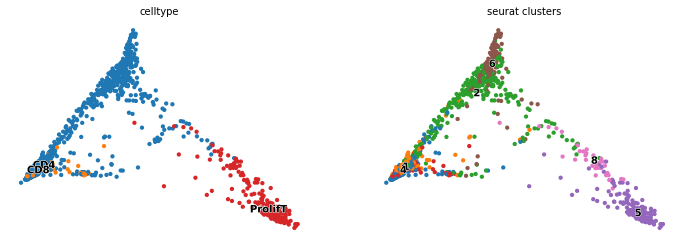

In [15]:
# DC1 is the x-axis here :)
cm = 1/2.54  # centimeters in inches
scv.pl.scatter(adata, basis='diffmap', color=['celltype','seurat_clusters'], legend_loc='on data')

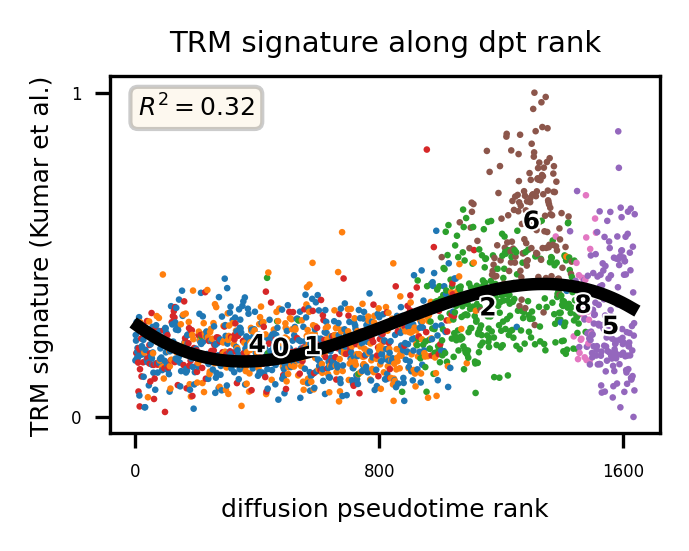

In [17]:
scv.pl.scatter(adata[np.argsort(adata.obsm['X_diffmap'][:,1])], x=np.arange(adata.n_obs), y=adata[np.argsort(adata.obsm['X_diffmap'][:,1])].obs.kumar_TRM_cell_signature_score, color='seurat_clusters', 
               legend_loc='on data', add_polyfit=3, linewidth=3, dpi=300, show=False, xlabel='diffusion pseudotime rank', ylabel='TRM signature (Kumar et al.)',
               figsize=[6*cm, 4*cm], s=10, fontsize=6, legend_fontsize=6
              )
pl.title('TRM signature along dpt rank', fontsize=7)
pl.savefig('../figures/Fig4K_TRM_diffusion.pdf', bbox_inches='tight', dpi=300)
pl.show()

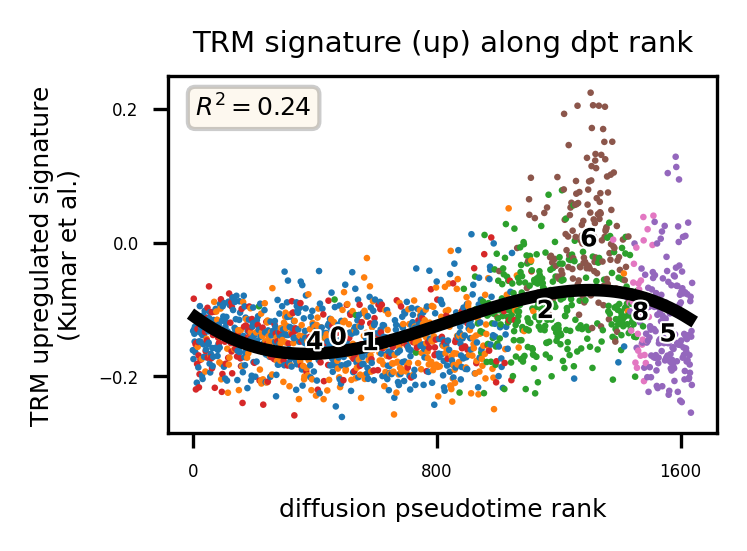

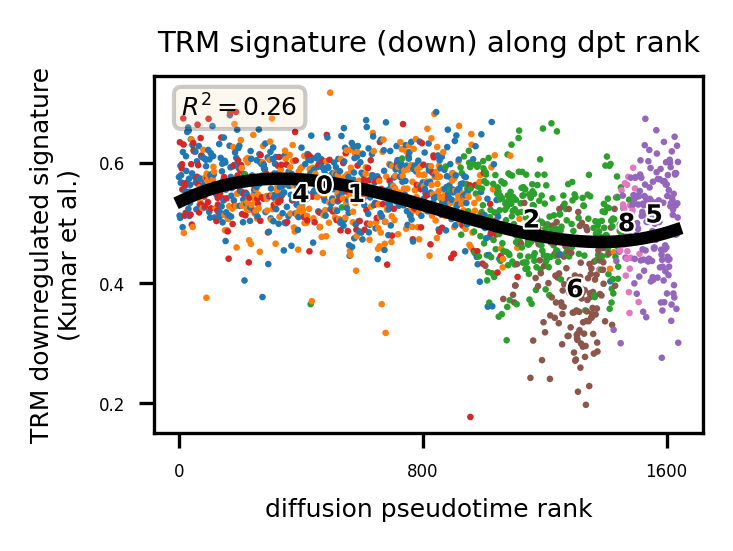

In [18]:
scv.pl.scatter(adata[np.argsort(adata.obsm['X_diffmap'][:,1])], x=np.arange(adata.n_obs), y=adata[np.argsort(adata.obsm['X_diffmap'][:,1])].obs.kumar_up, color='seurat_clusters', 
               legend_loc='on data', add_polyfit=3, linewidth=3, dpi=300, show=False, xlabel='diffusion pseudotime rank', ylabel='TRM upregulated signature\n(Kumar et al.)',
               figsize=[6*cm, 4*cm], s=10, fontsize=6, legend_fontsize=6
              )
pl.title('TRM signature (up) along dpt rank', fontsize=7)
pl.savefig('../figures/FigS15_TRM_diffusion_up.pdf', bbox_inches='tight', dpi=300)
pl.show()

scv.pl.scatter(adata[np.argsort(adata.obsm['X_diffmap'][:,1])], x=np.arange(adata.n_obs), y=adata[np.argsort(adata.obsm['X_diffmap'][:,1])].obs.kumar_down, color='seurat_clusters', 
               legend_loc='on data', add_polyfit=3,linewidth=3, dpi=300, show=False, xlabel='diffusion pseudotime rank', ylabel='TRM downregulated signature\n(Kumar et al.)',
               figsize=[6*cm, 4*cm], s=10, fontsize=6, legend_fontsize=6
              )
pl.title('TRM signature (down) along dpt rank', fontsize=7)
pl.savefig('../figures/FigS15_TRM_diffusion_down.pdf', bbox_inches='tight', dpi=300)
pl.show()